## Fine-tuning ClinicalBERT for clinical assertion detection

In this blog post, we will show how to fine-tune a bert language model for a downstream task: clinical assertion detection. We are going to leverage the Hugging Face transformer library and the model hub. 

We will show how  :

1. Load and prepare the data for assertion dectection

2. Fine-tune an auto-encoding language model such as Clinical BERT

3. Evaluate and run Inference with the trained model

### 1. Background and Context 

#### Clinical assertion dectection

This work is based on the paper "Assertion Detection in Clinical Notes: Medical Language Models to the Rescue?" , using Language model for assertion detection. Assertion detection is the task to identify the assertion of an entity based on textual cues in unstructured text. In other words we want to classify the assertions made on given medical concepts as being :
* present
* absent
* possible in the patient
* conditionally present in the patient under certain circumstances
* hypothtically present in the patient at some future point
* mentioned in the patient report but associated with somenone else

For example given the text "The patient recovered during the night and now denies any shortness of breath.", the model should identify that the entity: shortness of breath is absent. 

#### The data

For this demo we use The 2010 i2b2/VA Workshop on Natural Language Processing Challenges for Clinical Records presented three tasks: a concept extraction task focused on the extraction of medical concepts from patient reports; an assertion classification task focused on assigning assertion types for medical problem concepts; 
and a relation classification task focused on assigning relation types that hold between medical problems, tests, and treatments. These are be available to the research community from [i2b2](https://i2b2.org/NLP/DataSets) portal under data use agreements. For more information please consult the paper [2010 i2b2/VA challenge on concepts, assertions, and relations in clinical text](https://academic.oup.com/jamia/article/18/5/552/830538)

You need to request access, download and extract  the data needed.

### 2. Install the dependencies

In this example we will use the Pytorch and HuggingFace library, an run the experiemnt on a Google Colab. You will also need to install spacy and the biomedical pretrained model  **en_ner_bc5cdr_md** a spaCy NER model trained on the BC5CDR corpus. The model en_ner_bc5cdr_md was trained for DISEASE and CHEMICAL entity recognition. To install all the dependencies run the following cell.

In [1]:
# install all the libraries and dependencies
#%pip install -r requirements.txt
#python=3.8
# conda install matplotlib numpy scikit-learn
# conda install pandas
# pip install spacy
# pip install scispacy ? gave error ignored
# pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
# conda install pytorch torchvision -c pytorch
# pip install ipykernel
# pip install transformers
# pip install datasets
# pip install evaluate
# pip install accelerate -U

### 3. Load and prepare the data

We will use the assertion classification data from i2b2, which consist of XXXXX records of discharge summary notes. 

In [2]:
import os
import re
import en_ner_bc5cdr_md
import spacy
import copy
import pandas as pd

# Get paths for data and labels
cwd  = os.getcwd()
labels_path_beth = os.path.join(cwd,"Data/concept_assertion_relation_training_data","beth","ast")
data_path_beth = os.path.join(cwd,"Data/concept_assertion_relation_training_data","beth","txt")
labels_path_partners = os.path.join(cwd,"Data/concept_assertion_relation_training_data","partners","ast")
data_path_partners = os.path.join(cwd,"Data/concept_assertion_relation_training_data","partners","txt")
print(labels_path_beth)
print(data_path_beth)
print(labels_path_partners)
print(data_path_partners)

C:\Users\kcaro\miniconda3\envs\clinical-adapter\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.5.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/concept_assertion_relation_training_data\beth\ast
C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/concept_assertion_relation_training_data\beth\txt
C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/concept_assertion_relation_training_data\partners\ast
C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/concept_assertion_relation_training_data\partners\txt


In [3]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.
    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    text = text.strip().lower()
    text = re.sub(r'[^\x00-\x7f]',r'', text) 
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = " ".join(text.split())
    
    return text

In [4]:
# Create list of .txt clinical notes for each dataset (beth and partners)
def list_files_in_directory(directory_path):
    ignore = ['.DS_Store']
    files = os.listdir(directory_path)
    files = [file for file in files if os.path.isfile(os.path.join(directory_path, file)) and file not in ignore]
    files = [file[:-4] for file in files]
    
    return files

notes_beth = list_files_in_directory(data_path_beth)
notes_partners = list_files_in_directory(data_path_partners)

In [5]:
def load_clinical_notes_dict(notes, data_path):
    content_notes = {}
    for note in notes:
        _file = os.path.join(data_path, note + '.txt')
        with open(_file) as f:
            content = f.read()
            content_notes[note] = content
    return content_notes

content_beth_dict = load_clinical_notes_dict(notes_beth, data_path_beth)
content_partners_dict = load_clinical_notes_dict(notes_partners, data_path_partners)

# Merge the content dictionaries into one
content_dict = {**content_beth_dict, **content_partners_dict}

print("Number of beth notes:", len(content_beth_dict))
print("Number of partners notes:", len(content_partners_dict))
print("Number of combined notes:", len(content_dict))

Number of beth notes: 73
Number of partners notes: 97
Number of combined notes: 170


In [6]:
def load_notes_labels_dict(notes, labels_path):
    labels_notes = {}
    for note in notes:
        _file = os.path.join(labels_path, note + '.ast')
        with open(_file) as f:
            content = f.read()
            line_dict = {}
            for line in content:
                
                
                labels_notes[note] = content
            
    f.close()
    return labels_notes

labels_beth_dict  = load_notes_labels_dict(notes_beth, labels_path_beth)
labels_partners_dict = load_notes_labels_dict(notes_partners, labels_path_partners)

# # Merge the labels into one list
labels_dict = {**labels_beth_dict, **labels_partners_dict}
print("Number of beth with labels:", len(labels_beth_dict))
print("Number of partners with labels:", len(labels_partners_dict))
print("Number of combined with labels:", len(labels_dict))

Number of beth with labels: 72
Number of partners with labels: 96
Number of combined with labels: 168


In [7]:
keys_unique_to_content_dict = set(content_dict.keys()) - set(labels_dict.keys())
keys_unique_to_labels_dict = set(labels_dict.keys()) - set(content_dict.keys())
print("Keys Unique to content:", keys_unique_to_content_dict)
print("Keys Unique to labels:", keys_unique_to_labels_dict)

Keys Unique to content: {'262182942', 'record-58'}
Keys Unique to labels: set()


In [8]:
def create_labels_dict(labels):
    labels_dict = {}
    for key in labels:
        lines = labels[key].split("\n")
        line_dict = {}
        i = 1
        for line in lines:
            if line != '':
                ast = line.strip().split('||')
                assertion = re.findall('"([^"]*)"', ast[2])[0]
                entity = re.findall('"([^"]*)"', ast[0])[0]
                pattern = re.compile(r'c="[^"]*"([^"]+)')
                loc = pattern.search(ast[0]).group(1)
                loc = loc[1:]
                start, end = loc.split(' ')
                s_line, s_tok = start.split(':')
                e_line, e_tok = end.split(':')

                line_info = {'location': [int(s_line), int(s_tok), int(e_line), int(e_tok)], 'problem': entity, 'assertion': assertion}
                line_dict[i] = line_info
                i+= 1
        labels_dict[key] = line_dict
            
    return labels_dict

new_labels = create_labels_dict(labels_dict)

total_labels = 0
for record_labels in new_labels.values():
    total_labels += len(record_labels)
    
print("total number of labels for data:", total_labels)

total number of labels for data: 7073


In [9]:
new_labels['record-105']

{1: {'location': [55, 6, 55, 8],
  'problem': 'left basilar atelectasis',
  'assertion': 'present'},
 2: {'location': [143, 1, 143, 2],
  'problem': 'ventral hernia',
  'assertion': 'present'},
 3: {'location': [26, 0, 26, 0], 'problem': 'htn', 'assertion': 'present'},
 4: {'location': [68, 1, 68, 3],
  'problem': 'spontaneous echo contrast',
  'assertion': 'absent'},
 5: {'location': [21, 6, 21, 8],
  'problem': '80% lm lesion',
  'assertion': 'present'},
 6: {'location': [54, 2, 54, 3],
  'problem': 'interstitial edema',
  'assertion': 'absent'},
 7: {'location': [18, 5, 18, 6],
  'problem': 'abnormal ekg',
  'assertion': 'present'},
 8: {'location': [143, 0, 143, 0], 'problem': 'htn', 'assertion': 'present'},
 9: {'location': [14, 2, 14, 4],
  'problem': 'recent mild angina',
  'assertion': 'conditional'},
 10: {'location': [19, 12, 19, 13],
  'problem': 'perfusion defects',
  'assertion': 'present'},
 11: {'location': [98, 3, 98, 3], 'problem': 'ai', 'assertion': 'present'},
 12: {

In [10]:
def create_content_dict(content):
    new_content = {}
    for key in content:
        lines = content[key].split("\n")
        line_dict = {}
        i = 1
        for line in lines:
            line_dict[i] = line
            i += 1
            
        new_content[key] = line_dict
    return new_content

new_content = create_content_dict(content_dict)

In [11]:
new_content['record-105']

{1: 'Admission Date :',
 2: '2017-06-13',
 3: 'Discharge Date :',
 4: '2017-06-17',
 5: 'Date of Birth :',
 6: '1956-02-17',
 7: 'Sex :',
 8: 'M',
 9: 'Service :',
 10: 'CARDIOTHORACIC',
 11: 'Allergies :',
 12: 'Patient recorded as having No Known Allergies to Drugs',
 13: 'Attending:Jordan U Kostohryz , M.D.',
 14: 'Chief Complaint: recent mild angina with exertion',
 15: 'Major Surgical or Invasive Procedure : ',
 16: 'emergency CABG X 3 ( 2017-06-13 )( LIMA to LAD , SVG to ramus , SVG to OM )',
 17: 'History of Present Illness :',
 18: '61 yo African-American-Hispanic male had abnormal EKG found as part of pre-op eval. for ventral hernia repair .',
 19: 'Had subsequent abnormal stress test and pefusion imaging showed EF 38% with perfusion defects .',
 20: 'Echo prior to scheduled cath showed mild LVH , inferior HK , EF 40% , mild MR , mild LAE .',
 21: 'Cath at Kindred/North Shore today showed 80% LM lesion with normal LAD , CX , RCA .',
 22: 'Severe systolic HTN also noted .',
 23

In [12]:
def add_entity_and_assertion(new_labels, new_content):
    data = {}
    for record in new_labels:
        i = 1
        data[record] = {}
        new_record = []
        for key in new_labels[record]:
            s_line = new_labels[record][key]['location'][0]
            s_tok = new_labels[record][key]['location'][1]
            e_line = new_labels[record][key]['location'][2]
            e_tok = new_labels[record][key]['location'][3]
            assertion = new_labels[record][key]['assertion']
            sent = new_content[record][s_line]
            words = sent.split()
            words.insert(s_tok, '[entity]')
            words.insert(e_tok + 2, '[entity]')
            new_sent = ' '.join(words)
            data[record][i] = {'line': s_line, 'sent': new_sent, 'label': assertion}
            i += 1
        
    return data

data = add_entity_and_assertion(new_labels, new_content)

In [13]:
# for i in data['record-105']:
#     print(data['record-105'][i]['new'])

In [14]:
total_sents = 0
for record_labels in data.values():
    total_sents += len(record_labels)
    
print("total number of sentences in data:", total_labels)

total number of sentences in data: 7073


In [15]:
print(data['record-106'][52]['sent']), print(data['record-106'][52]['label'])

Can give 40 lasix PO if having any [entity] weight gain [entity] or shortness of breath .
hypothetical


(None, None)

In [16]:
data['record-106'][53]['sent']

'Can give 40 lasix PO if having any weight gain or [entity] shortness of breath [entity] .'

# data

In [17]:
# for i in data['record-105']:
#     print(data['record-105'][i]['sent'])

In [18]:
record_dfs = []
for record, info in data.items():
    df = pd.DataFrame.from_dict(info, orient='index')
    df['record'] = record
    record_dfs.append(df)
final_df = pd.concat(record_dfs).reset_index(drop=True)
final_df = final_df[['record', 'line', 'sent', 'label']]
allowed_labels = ['present', 'absent', 'possible']
filtered_df = final_df[final_df['label'].isin(allowed_labels)]
filtered_df.reset_index(inplace=True)

In [31]:
final_df

,record,line,sent,label
0,record-105,55,There has been interval improvement in [entity...,present
1,record-105,143,HTN [entity] ventral hernia [entity] right nep...,present
2,record-105,26,[entity] HTN [entity] elev. chol. right facial...,present
3,record-105,68,No [entity] spontaneous echo contrast [entity]...,absent
4,record-105,21,Cath at Kindred/North Shore today showed [enti...,present
...,...,...,...,...
7068,989519730_WGH,44,On exam she is [entity] afebrile [entity] .,absent
7069,989519730_WGH,49,Heart is regular without [entity] murmurs [ent...,absent
7070,989519730_WGH,72,She is to also call the office if she has any ...,hypothetical
7071,989519730_WGH,39,No [entity] known drug allergies [entity] .,absent


In [20]:
max_length = filtered_df['sent'].str.len().max()
max_length

775

In [21]:
min_length = filtered_df['sent'].str.len().min()
min_length

20

In [22]:
# for i in range(len(filtered_df)):
#     print(i, filtered_df['record'][i], filtered_df['line'][i], len(filtered_df['sent'][i]))

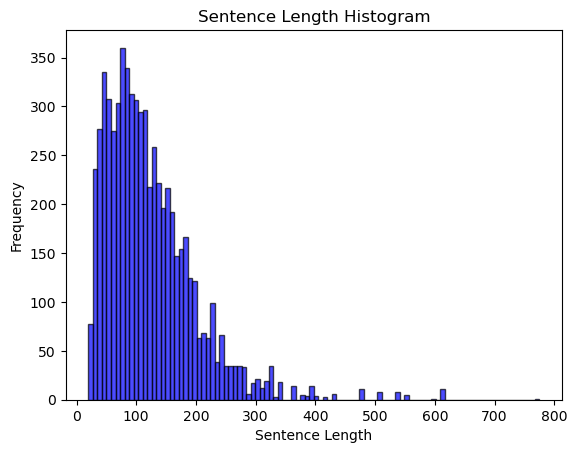

In [23]:
import matplotlib.pyplot as plt
sentence_lengths = filtered_df['sent'].str.len()

plt.hist(sentence_lengths, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Histogram')
plt.show()

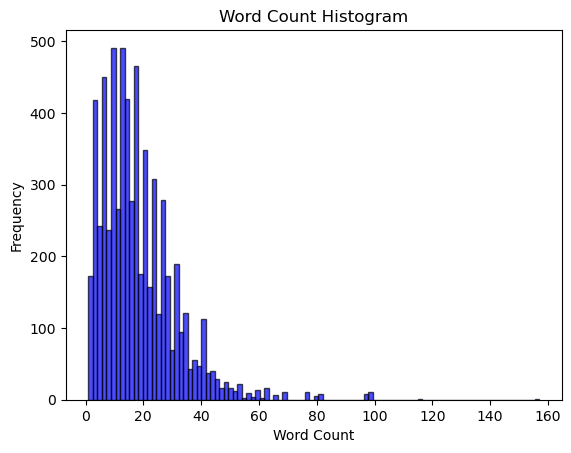

In [24]:
word_counts = filtered_df['sent'].apply(lambda x: len(x.split()))-2
plt.hist(word_counts, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Histogram')
plt.show()

In [25]:
word_counts[0:20]

0     10
1      9
2     16
3     14
4     17
5      7
6     18
7      9
8     15
9      7
10     1
11     9
12    15
13     8
14     6
15    12
16     8
17    11
18     6
19     7
Name: sent, dtype: int64

In [28]:
word_counts[word_counts == 1]

10      1
78      1
102     1
111     1
173     1
311     1
362     1
713     1
790     1
810     1
872     1
1967    1
1998    1
2019    1
2020    1
2023    1
2026    1
2107    1
2115    1
2277    1
2371    1
2516    1
2955    1
3155    1
3176    1
3188    1
3234    1
3277    1
3295    1
3320    1
3429    1
3431    1
3433    1
3438    1
3439    1
3516    1
3941    1
3953    1
4892    1
5629    1
5639    1
5794    1
6136    1
6141    1
6144    1
6151    1
6318    1
Name: sent, dtype: int64

In [29]:
filtered_df.iloc[10].values

array([11, 'record-105', 142, '[entity] CAD [entity]', 'present'],
      dtype=object)

In [42]:
# def create_content_dict(content):
#     new_content = {}
#     for key in content:
#         note = content[key].replace("\n"," ")
#         clean_note = clean_text(note)
# #         print(clean_note)
#         new_content[key] = clean_note
        
#     return new_content

# new_content_dict = create_content_dict(content_dict)

In [ ]:
# def split_note_sentences(content_records):
#     # load spacy
#     nlp1 = spacy.load("en_ner_bc5cdr_md",disable = ['parser'])
#     nlp1.add_pipe('sentencizer')

#     # transform the data into a list of sentences
#     docs = [(r,nlp1(text)) for r,text in content_records]
#     data = []
#     for r,doc in docs:
#         for s in doc.sents:
#             sentence = str.strip(str(s))
#             sentence = sentence.replace("\n"," ")
#             data.append((r,sentence))
    
#     return data

# data = split_note_sentences(content)

In [ ]:

# def split_note_sentences(content_records):
#     # load spacy
#     nlp1 = spacy.load("en_ner_bc5cdr_md",disable = ['parser'])
#     nlp1.add_pipe('sentencizer')

#     # transform the data into a list of sentences
#     docs = [(r,nlp1(text)) for r,text in content_records]
#     data = []
#     for r,doc in docs:
#         for s in doc.sents:
#             sentence = str.strip(str(s))
#             sentence = sentence.replace("\n"," ")
#             data.append((r,sentence))
    
#     return data

# data = split_note_sentences(content)

In [12]:
def create_content_dict(content):
    new_content = {}
    for key in content:
        content[key]replace
#         clean_content = clean_text(content[key])
#         lines = content[key].split("\n")
#         line_dict = {}
#         i = 1
#         for line in lines:
#             clean_line = clean_text(line)
#             line_dict[i] = clean_line
#             i += 1
        new_content[key] = content
        
    return new_content

new_content_dict = create_content_dict(content_dict)

In [13]:
new_content_dict

{'record-105': 'admission date 2017 06 13 discharge date 2017 06 17 date of birth 1956 02 17 sex m service cardiothoracic allergies patient recorded as having no known allergies to drugs attending jordan u kostohryz m d chief complaint recent mild angina with exertion major surgical or invasive procedure emergency cabg x 3 2017 06 13 lima to lad svg to ramus svg to om history of present illness 61 yo african american hispanic male had abnormal ekg found as part of pre op eval for ventral hernia repair had subsequent abnormal stress test and pefusion imaging showed ef 38 with perfusion defects echo prior to scheduled cath showed mild lvh inferior hk ef 40 mild mr mild lae cath at kindred north shore today showed 80 lm lesion with normal lad cx rca severe systolic htn also noted transferred in urgently for cabg with dr howard past medical history ventral hernia htn elev chol right facial droop with metal plate secondary to gsw to face right nephrectomy social history current smoker famil

In [11]:
new_content_dict['record-34']

{1: 'admission date',
 2: '2008 12 24',
 3: 'discharge date',
 4: '2009 02 06',
 5: 'date of birth',
 6: '2008 12 24',
 7: 'sex',
 8: 'f',
 9: 'service',
 10: 'neonatology',
 11: 'history of present illness',
 12: 'gerardo is the 1400 gm product of a 32 05 03 week twin gestation born to a 37 year old gravida 1 para 0 mother',
 13: 'prenatal laboratory values',
 14: 'maternal blood type 0 positive dat negative negative rpr nonreactive',
 15: 'the mother s past medical history is significant for',
 16: '1 tuberculosis mother was treated in 2001 according to chart with subsequent negative chest x ray and',
 17: '2 infertility',
 18: 'the pregnancy was complicated by twin gestation and by polyhydramnios with apparent duodenal atresia and nuchal',
 19: 'thickening consistent with trisomy 21 in the b co twin',
 20: 'amniocentesis was not performed',
 21: 'maternal hypertension was noted in the doctor s office and mom was referred to nonreassuring fetal tracing necessitating an urgent cesarea

In [10]:
new_labels['record-105']

{1: {'location': ['55', '6', '55', '8'],
  'problem': 'left basilar atelectasis',
  'assertion': 'present'},
 2: {'location': ['143', '1', '143', '2'],
  'problem': 'ventral hernia',
  'assertion': 'present'},
 3: {'location': ['26', '0', '26', '0'],
  'problem': 'htn',
  'assertion': 'present'},
 4: {'location': ['68', '1', '68', '3'],
  'problem': 'spontaneous echo contrast',
  'assertion': 'absent'},
 5: {'location': ['21', '6', '21', '8'],
  'problem': '80% lm lesion',
  'assertion': 'present'},
 6: {'location': ['54', '2', '54', '3'],
  'problem': 'interstitial edema',
  'assertion': 'absent'},
 7: {'location': ['18', '5', '18', '6'],
  'problem': 'abnormal ekg',
  'assertion': 'present'},
 8: {'location': ['143', '0', '143', '0'],
  'problem': 'htn',
  'assertion': 'present'},
 9: {'location': ['14', '2', '14', '4'],
  'problem': 'recent mild angina',
  'assertion': 'conditional'},
 10: {'location': ['19', '12', '19', '13'],
  'problem': 'perfusion defects',
  'assertion': 'prese

In [5]:
# Split each note into sentences using the spacy biomedical pretrained model (en_ner_bc5cdr_md) ~22 seconds
import en_ner_bc5cdr_md
import spacy

def split_note_sentences(content_records):
    # load spacy
    nlp1 = spacy.load("en_ner_bc5cdr_md",disable = ['parser'])
    nlp1.add_pipe('sentencizer')

    # transform the data into a list of sentences
    docs = [(r,nlp1(text)) for r,text in content_records]
    data = []
    for r,doc in docs:
        for s in doc.sents:
            sentence = str.strip(str(s))
            sentence = sentence.replace("\n"," ")
            data.append((r,sentence))
    
    return data

data = split_note_sentences(content)

C:\Users\kcaro\miniconda3\envs\clinical-adapter\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.5.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [6]:
data[0]

('record-105',
 'Admission Date : 2017-06-13 Discharge Date : 2017-06-17 Date of Birth : 1956-02-17 Sex : M Service : CARDIOTHORACIC Allergies : Patient recorded as having No Known Allergies to Drugs Attending:Jordan U Kostohryz , M.D. Chief Complaint: recent mild angina with exertion Major Surgical or Invasive Procedure :  emergency CABG X 3 ( 2017-06-13 )( LIMA to LAD , SVG to ramus , SVG to OM ) History of Present Illness : 61 yo African-American-Hispanic male had abnormal EKG found as part of pre-op eval.')

The next step is to load and process the labels. They are provided as ast files.

In [172]:
# Load and process the labels into a list of lists for each note. [[['note_id', 'assertion', 'lable', 'entity'], ...], ...]
# They are provided as ast files.
import re
import pandas as pd 

def load_notes_labels(notes, labels_path):
    labels_notes = []
    for note in notes:
        _file = os.path.join(labels_path, note + '.ast')
        with open(_file) as f:
            content = f.readlines()
            file_data = []
            for line in content:
                ast = line.strip().split('||')
                line_entity = []

                assertion = ast[2].split('=')
                entity_label = ast[1].split("=")
                entity_text = re.findall('"([^"]*)"', ast[0])
                pattern = re.compile(r'c="[^"]*"([^"]+)')
                loc = pattern.search(ast[0]).group(1)
                loc = loc[1:]
                
                line_entity.append(note)
                line_entity.append(assertion[1].replace('"',''))
                line_entity.append(entity_label[1].replace('"',''))
                line_entity.append(entity_text[0])
                line_entity.append(loc)
                
                file_data.append(line_entity)
        labels_notes.append(file_data)
        

    f.close()

    return labels_notes

labels_beth  = load_notes_labels(notes_beth, labels_path_beth)
labels_partners = load_notes_labels(notes_partners, labels_path_partners)

# Merge the labels into one list
labels = labels_beth + labels_partners
print("Number of beth labels:", len(labels_beth))
print("Number of partners labels:", len(labels_partners))
print("Number of combined labels:", len(labels))

# labels in a dataframe and sort by record, start line, start token (add occurance)
data_labels = [line for f in labels for line in f]
df_data_labels = pd.DataFrame(data_labels,columns=['record','assertion','label','entity', 'loc'])
df_data_labels[['start', 'end']] = df_data_labels['loc'].str.split(' ', expand=True)
df_data_labels[['start line', 'start token']] = df_data_labels['start'].str.split(':', expand=True)
df_data_labels[['end line', 'end token']] = df_data_labels['end'].str.split(':', expand=True)
df_data_labels = df_data_labels.drop(columns=['loc', 'start', 'end'])
df_data_labels[['start line', 'start token', 'end line', 'end token']] = df_data_labels[['start line', 'start token', 'end line', 'end token']].astype(int)
df_data_labels = df_data_labels.sort_values(['record', 'start line', 'start token']).reset_index(drop=True)
df_data_labels['occurrence'] = df_data_labels.groupby(['record', 'entity']).cumcount() + 1

print("Number of entities classified:", len(df_data_labels))
df_data_labels.head()

['55:6', '55:8']
['143:1', '143:2']
['26:0', '26:0']
['68:1', '68:3']
['21:6', '21:8']
['54:2', '54:3']
['18:5', '18:6']
['143:0', '143:0']
['14:2', '14:4']
['19:12', '19:13']
['98:3', '98:3']
['142:0', '142:0']
['12:5', '12:6']
['19:2', '19:4']
['87:5', '87:6']
['90:0', '90:2']
['72:2', '72:6']
['91:5', '91:6']
['92:1', '92:1']
['94:3', '94:4']
['56:0', '56:2']
['89:3', '89:5']
['93:0', '93:2']
['98:0', '98:1']
['26:3', '26:5']
['26:11', '26:11']
['25:0', '25:1']
['85:2', '85:3']
['84:2', '84:3']
['108:0', '108:0']
['83:2', '83:3']
['75:1', '75:3']
['26:1', '26:2']
['82:2', '82:3']
['22:0', '22:2']
['81:5', '81:6']
['79:6', '79:8']
['145:20', '145:21']
['73:2', '73:6']
['79:0', '79:4']
['78:3', '78:5']
['76:2', '76:7']
['77:6', '77:7']
['92:3', '92:3']
['88:3', '88:3']
['71:1', '71:3']
['88:1', '88:1']
['130:16', '130:16']
['107:7', '107:8']
['20:15', '20:16']
['20:9', '20:10']
['70:1', '70:1']
['20:18', '20:19']
['20:6', '20:7']
['69:5', '69:5']
['67:4', '67:5']
['69:1', '69:3']
['61

,record,assertion,label,entity,start line,start token,end line,end token,occurrence
0,018636330_DH,present,problem,c5-6 disc herniation,21,0,21,2,1
1,018636330_DH,present,problem,cord compression,21,4,21,5,1
2,018636330_DH,present,problem,myelopathy,21,7,21,7,1
3,018636330_DH,present,problem,bilateral hand numbness,25,11,25,13,1
4,018636330_DH,present,problem,occasional weakness,25,15,25,16,1


In [87]:
data[0]

('record-105',
 'Admission Date : 2017-06-13 Discharge Date : 2017-06-17 Date of Birth : 1956-02-17 Sex : M Service : CARDIOTHORACIC Allergies : Patient recorded as having No Known Allergies to Drugs Attending:Jordan U Kostohryz , M.D. Chief Complaint: recent mild angina with exertion Major Surgical or Invasive Procedure :  emergency CABG X 3 ( 2017-06-13 )( LIMA to LAD , SVG to ramus , SVG to OM ) History of Present Illness : 61 yo African-American-Hispanic male had abnormal EKG found as part of pre-op eval.')

In [88]:
df_data_labels[df_data_labels['record'] == 'record-105']

,record,assertion,label,entity,start line,start token,end line,end token,occurrence
2886,record-105,absent,problem,known allergies,12,5,12,6,1
2887,record-105,conditional,problem,recent mild angina,14,2,14,4,1
2888,record-105,present,problem,abnormal ekg,18,5,18,6,1
2889,record-105,present,problem,abnormal stress test,19,2,19,4,1
2890,record-105,present,problem,perfusion defects,19,12,19,13,1
2891,record-105,present,problem,mild lvh,20,6,20,7,1
2892,record-105,present,problem,inferior hk,20,9,20,10,1
2893,record-105,present,problem,mild mr,20,15,20,16,1
2894,record-105,present,problem,mild lae,20,18,20,19,1
2895,record-105,present,problem,80% lm lesion,21,6,21,8,1


### 4. Annotate text for clinical assertion detection

After pre-processing the data we need to annotate each entity in our training data between the token '[entity]' .

In [9]:
import re

def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # remove all non-ASCII characters:
    text = re.sub(r'[^\x00-\x7f]',r'', text) 
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = " ".join(text.split())
    
    return text

First, we need to map the data with the labels. We do so by using the record id and searching the entity name in the text to do the mapping.

In [10]:
def linking_train_labels_data(data, df_data_labels):
    new_data = []
    for r , sent in data:
        
        
        for index,row in df_data_labels.loc[df_data_labels['record'] == r,['entity','assertion']].iterrows():
            entity = clean_text(row['entity'])
            sentence = clean_text(sent)
            #print(entity,sent)
            try:
                if re.search(r'\b' + str(entity) + r'\b', str(sentence)):
                    new_data.append((r,entity,sentence,row['assertion']))
            except:
                print(r)
                print("entity:",str(entity))
                print("****")
                
    return new_data

In [11]:
# ~50 seconds
new_data = linking_train_labels_data(data,df_data_labels)

In [77]:
new_data[0]

('record-105',
 'abnormal ekg',
 'admission date 2017 06 13 discharge date 2017 06 17 date of birth 1956 02 17 sex m service cardiothoracic allergies patient recorded as having no known allergies to drugs attending jordan u kostohryz m d chief complaint recent mild angina with exertion major surgical or invasive procedure emergency cabg x 3 2017 06 13 lima to lad svg to ramus svg to om history of present illness 61 yo african american hispanic male had abnormal ekg found as part of pre op eval',
 'present')

In [82]:
df_data_labels[df_data_labels['record'] == 'record-15']

,record,assertion,label,entity,start line,start token,end line,end token
4112,record-15,present,problem,very mild left lower extremity pain,15,2,15,7
4113,record-15,present,problem,coronary artery disease,19,1,19,3
4114,record-15,present,problem,congestive heart failure,20,1,20,3
4115,record-15,present,problem,acute renal failure,21,1,21,3
4116,record-15,present,problem,acute myocardial infarction,22,1,22,3
4117,record-15,present,problem,osteomyelitis,23,1,23,1
4118,record-15,present,problem,diabetes mellitus,24,1,24,2
4119,record-15,present,problem,osteomyelitis,33,13,33,13
4120,record-15,present,problem,osteomyelitis,34,12,34,12


In [83]:
df_data_labels['occurrence'] = df_data_labels.groupby(['record', 'entity']).cumcount() + 1

In [91]:
data[0]

('record-105',
 'Admission Date : 2017-06-13 Discharge Date : 2017-06-17 Date of Birth : 1956-02-17 Sex : M Service : CARDIOTHORACIC Allergies : Patient recorded as having No Known Allergies to Drugs Attending:Jordan U Kostohryz , M.D. Chief Complaint: recent mild angina with exertion Major Surgical or Invasive Procedure :  emergency CABG X 3 ( 2017-06-13 )( LIMA to LAD , SVG to ramus , SVG to OM ) History of Present Illness : 61 yo African-American-Hispanic male had abnormal EKG found as part of pre-op eval.')

In [92]:
for r , sent in data:
    print(r, sent)

record-105 Admission Date : 2017-06-13 Discharge Date : 2017-06-17 Date of Birth : 1956-02-17 Sex : M Service : CARDIOTHORACIC Allergies : Patient recorded as having No Known Allergies to Drugs Attending:Jordan U Kostohryz , M.D. Chief Complaint: recent mild angina with exertion Major Surgical or Invasive Procedure :  emergency CABG X 3 ( 2017-06-13 )( LIMA to LAD , SVG to ramus , SVG to OM ) History of Present Illness : 61 yo African-American-Hispanic male had abnormal EKG found as part of pre-op eval.
record-105 for ventral hernia repair .
record-105 Had subsequent abnormal stress test and pefusion imaging showed EF 38% with perfusion defects .
record-105 Echo prior to scheduled cath showed mild LVH , inferior HK , EF 40% , mild MR , mild LAE .
record-105 Cath at Kindred/North Shore today showed 80% LM lesion with normal LAD , CX , RCA .
record-105 Severe systolic HTN also noted .
record-105 Transferred in urgently for cabg with Dr. Howard .
record-105 Past Medical History : ventral 

Then, we can annotate each sentence with the token [entity].

In [13]:
def annotate_data(new_data):
    processed_data = []
    for r,entity,text,label in new_data:
        #print(text)
        match = re.search(r'\b' + entity + r'\b',text)

        res = list(text)
        res.insert(match.start(), '[entity] ')
        res.insert(match.end()+1, ' [entity]')
        res = ''.join(res)
        processed_data.append((r,entity,res,label))  

    return processed_data

processed_data =  annotate_data(new_data)

In [42]:
processed_data[0]

('record-105',
 'abnormal ekg',
 'admission date 2017 06 13 discharge date 2017 06 17 date of birth 1956 02 17 sex m service cardiothoracic allergies patient recorded as having no known allergies to drugs attending jordan u kostohryz m d chief complaint recent mild angina with exertion major surgical or invasive procedure emergency cabg x 3 2017 06 13 lima to lad svg to ramus svg to om history of present illness 61 yo african american hispanic male had [entity] abnormal ekg [entity] found as part of pre op eval',
 'present')

Finally , we create a dataframe where for our example we only keep 3 assertions labels : present , absent and possible.

In [15]:
prepare_data = [{'record': r, 'sentence':text , 'label':label,'idx':idx} for idx,(r, entity, text,label) in enumerate(processed_data)]

df_i2b2 = pd.DataFrame(prepare_data)
df_i2b2 = df_i2b2[(df_i2b2.label=='present') | (df_i2b2.label=='absent') | (df_i2b2.label=='possible') ].copy()
df_i2b2

,record,sentence,label,idx
0,record-105,admission date 2017 06 13 discharge date 2017 ...,present,0
2,record-105,admission date 2017 06 13 discharge date 2017 ...,absent,2
3,record-105,for [entity] ventral hernia [entity] repair,present,3
4,record-105,for [entity] ventral hernia [entity] repair,present,4
5,record-105,had subsequent abnormal stress test and pefusi...,present,5
...,...,...,...,...
10662,989519730_WGH,when she was taking clear liquids her [entity]...,present,10662
10665,989519730_WGH,[entity] pain [entity] regimen with good affect,present,10665
10668,989519730_WGH,with the help of physical therapy the patient ...,present,10668
10671,989519730_WGH,[entity] pain [entity],present,10671


In [45]:
df_i2b2[df_i2b2['record'] == 'record-105'][48:70]

,record,sentence,label,idx
49,record-105,the right ventricular cavity is [entity] mildl...,present,49
50,record-105,there are [entity] simple atheroma [entity] in...,present,50
51,record-105,there are [entity] simple atheroma [entity] in...,present,51
52,record-105,there are [entity] simple atheroma [entity] in...,present,52
53,record-105,there are [entity] simple atheroma [entity] in...,present,53
54,record-105,there are [entity] simple atheroma [entity] in...,present,54
55,record-105,there are [entity] simple atheroma [entity] in...,present,55
56,record-105,there are [entity] simple atheroma [entity] in...,present,56
57,record-105,there are [entity] simple atheroma [entity] in...,present,57
58,record-105,there are [entity] simple atheroma [entity] in...,present,58


In [49]:
print(df_i2b2.loc[50].values[1])
print(df_i2b2.loc[51].values[1])
print(df_i2b2.loc[52].values[1])
print(df_i2b2.loc[53].values[1])
print(df_i2b2.loc[54].values[1])
print(df_i2b2.loc[55].values[1])
print(df_i2b2.loc[56].values[1])
print(df_i2b2.loc[57].values[1])
print(df_i2b2.loc[58].values[1])
print(df_i2b2.loc[58].values[1])
print(df_i2b2.loc[59].values[1])
print(df_i2b2.loc[60].values[1])
print(df_i2b2.loc[61].values[1])
print(df_i2b2.loc[62].values[1])
print(df_i2b2.loc[63].values[1])
print(df_i2b2.loc[64].values[1])
print(df_i2b2.loc[65].values[1])

there are [entity] simple atheroma [entity] in the aortic root
there are [entity] simple atheroma [entity] in the aortic root
there are [entity] simple atheroma [entity] in the aortic root
there are [entity] simple atheroma [entity] in the aortic root
there are [entity] simple atheroma [entity] in the ascending aorta
there are [entity] simple atheroma [entity] in the ascending aorta
there are [entity] simple atheroma [entity] in the ascending aorta
there are [entity] simple atheroma [entity] in the ascending aorta
there are [entity] simple atheroma [entity] in the aortic arch
there are [entity] simple atheroma [entity] in the aortic arch
there are [entity] simple atheroma [entity] in the aortic arch
there are [entity] simple atheroma [entity] in the aortic arch
there are [entity] simple atheroma [entity] in the aortic arch
there are [entity] simple atheroma [entity] in the descending thoracic aorta
there are [entity] simple atheroma [entity] in the descending thoracic aorta
there are [

In [18]:
df_i2b2.iloc[0]

record                                             record-105
sentence    admission date 2017 06 13 discharge date 2017 ...
label                                                 present
idx                                                         0
Name: 0, dtype: object

In [54]:
prepare_data = [{'record': r, 'sentence': text.strip(), 'label': label, 'idx': idx}
                for idx, (r, entity, text, label) in enumerate(processed_data)]

df_i2b2_2 = pd.DataFrame(prepare_data)
df_i2b2_2 = df_i2b2_2[(df_i2b2_2.label == 'present') | (df_i2b2_2.label == 'absent') | (df_i2b2_2.label == 'possible')].copy()

In [56]:
df_i2b2_2[df_i2b2_2['record'] == 'record-105'][48:70]

,record,sentence,label,idx
49,record-105,the right ventricular cavity is [entity] mildl...,present,49
50,record-105,there are [entity] simple atheroma [entity] in...,present,50
51,record-105,there are [entity] simple atheroma [entity] in...,present,51
52,record-105,there are [entity] simple atheroma [entity] in...,present,52
53,record-105,there are [entity] simple atheroma [entity] in...,present,53
54,record-105,there are [entity] simple atheroma [entity] in...,present,54
55,record-105,there are [entity] simple atheroma [entity] in...,present,55
56,record-105,there are [entity] simple atheroma [entity] in...,present,56
57,record-105,there are [entity] simple atheroma [entity] in...,present,57
58,record-105,there are [entity] simple atheroma [entity] in...,present,58


In [70]:
for i in new_data:
    print(i[1])

abnormal ekg
recent mild angina
known allergies
ventral hernia
ventral hernia
perfusion defects
abnormal stress test
mild mr
inferior hk
mild lae
mild lvh
80 lm lesion
htn
htn
severe systolic htn
ventral hernia
htn
htn
ventral hernia
right facial droop
gsw
interstitial edema
left basilar atelectasis
right basilar atelectasis
bilateral pleural effusions
bibasilar minor atelectasis
persistent pleural effusions
mildly dilated
mildly dilated
spontaneous echo contrast
spontaneous echo contrast
spontaneous echo contrast
thrombus
spontaneous echo contrast
mass
mass thrombus
thrombus
atrial septal defect
mild symmetric left ventricular hypertrophy
mild symmetric left ventricular hypertrophy
mild symmetric left ventricular hypertrophy
mild symmetric left ventricular hypertrophy
left ventricular aneurysm
mild regional left ventricular systolic dysfunction
mildly depressed
ventricular septal defect
mild inferior hypokinesis
resting regional wall motion abnormalities
mildly dilated
mildly dilated


### 5.  Splitting the data and create dataset

We use sklearn to split the data into train, validation and test set. We have 80% for training, 10% for testing and 10% for validation.

In [35]:
from sklearn.model_selection import train_test_split

df_i2b2 = df_i2b2.sample(frac=0.2).copy()

X = df_i2b2['sentence']
y = df_i2b2['label']

X_train_valid,X_test,y_train_valid, y_test= train_test_split(X,y,test_size=0.1,stratify=y,random_state=42)
X_train,X_valid,y_train,y_valid = train_test_split(X_train_valid,y_train_valid,train_size=0.8,random_state=42,stratify=y_train_valid)

print(f"X_train shape {X_train.shape} y_train shape : {y_train.shape}")
print(f"X_valid shape {X_valid.shape} y_valid shape : {y_valid.shape}")
print(f"X_test shape {X_test.shape} y_test shape : {y_test.shape}")

X_train shape (873,) y_train shape : (873,)
X_valid shape (219,) y_valid shape : (219,)
X_test shape (122,) y_test shape : (122,)


In [36]:
import numpy as np
print(X_train.shape,y_train.shape)
np.vstack((y_train,X_train))

(873,) (873,)


array([['present', 'present', 'absent', ..., 'present', 'present',
        'absent'],
       ['[entity] nephrolithiasis [entity]',
        'mr mackey also had signs and symptoms consistent with cervical myelopathy a cervical mri scan showed very impressive disc herniations at c5 c6 less so at c4 c5 with [entity] clear cut cord compression [entity] particularly on the right side c5 c6',
        'pt feeling well denies [entity] abd pain [entity] n v lh sob cp',
        ...,
        'past medical history aicd pocket infection c b mssa bacteremia pericardial effusion s p mediastinal exploration evacuation of pericardial effusion hematoma 2017 07 24 ischemic colitis and ischemic liver 2017 06 22 post air embolism from post mediastinal exploration cad s p lad ptca 33 years ago [entity] t2dm [entity] c b neuropathy and nephropathy copd hypothyroidism cva s p bovine avr 1999 hyperlipidemia gerd chronic lbp lumbar sympathectomy social history the patient is a retired truck driver',
        '[en

We also use sklearn to encode our labels

In [37]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("Encoding Labels .....")
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encode = np.asarray(encoder.transform(y_train))
y_valid_encode = np.asarray(encoder.transform(y_valid))
y_test_encode = np.asarray(encoder.transform(y_test))

Encoding Labels .....


In [38]:
X_train

6220                    [entity] nephrolithiasis [entity]
671     mr mackey also had signs and symptoms consiste...
3849    pt feeling well denies [entity] abd pain [enti...
5917    pertinent results 2018 12 26 11 10 pm lactate ...
4968    admission date 2013 12 24 discharge date 2014 ...
                              ...                        
3948    the patient denies [entity] any chest pain [en...
3229    past medical history htn afib sss copd cad pac...
5354    past medical history aicd pocket infection c b...
6245    [entity] end stage renal disease [entity] stat...
2962    his right tib fib fracture was repaired by ort...
Name: sentence, Length: 873, dtype: object

In [39]:
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict


train_df = pd.DataFrame(X_train)
valid_df = pd.DataFrame(X_valid)
test_df = pd.DataFrame(X_test)

train_df['label'] = y_train_encode.tolist()
valid_df['label'] = y_valid_encode.tolist()
test_df['label'] = y_test_encode.tolist()

print(train_df.head())

ds = DatasetDict ({
 'train': Dataset.from_pandas(train_df),
 'validation': Dataset.from_pandas(valid_df),
 'test': Dataset.from_pandas(test_df)
})

C:\Users\kcaro\miniconda3\envs\clinical-adapter\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                               sentence  label
6220                  [entity] nephrolithiasis [entity]      2
671   mr mackey also had signs and symptoms consiste...      2
3849  pt feeling well denies [entity] abd pain [enti...      0
5917  pertinent results 2018 12 26 11 10 pm lactate ...      2
4968  admission date 2013 12 24 discharge date 2014 ...      2


In [22]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 873
    })
    validation: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 219
    })
    test: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 122
    })
})

### 6.  Fine-tuning ClinicalBERT

In [23]:
import torch 
# setting device on GPU if available, else CPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [24]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModel 
tokenizer_clinical_bio  = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT",model_max_length=150)
model_clinical = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT", 
                                                                    num_labels=3,id2label={0: 'PRESENT', 1: 'ABSENT', 2:'POSSIBLE'})

(…)ge_Summary_BERT/resolve/main/config.json: 100%|████████████████████████████████████████████| 385/385 [00:00<?, ?B/s]
C:\Users\kcaro\miniconda3\envs\clinical-adapter\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kcaro\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
(…)arg

In [25]:
model_clinical

BertForSequenceClassification(
  (shared_parameters): ModuleDict()
  (bert): BertModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (key): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (value): Linear(
                in_features=7

In [26]:
model_clinical = model_clinical.to(device)

In [27]:
special_tokens_dict = {"additional_special_tokens": ["[entity]"]}
num_added_toks = tokenizer_clinical_bio.add_special_tokens(special_tokens_dict,False)

print("We have added", num_added_toks, "tokens")
# Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e., the length of the tokenizer.
model_clinical.resize_token_embeddings(len(tokenizer_clinical_bio))

We have added 1 tokens


Embedding(28997, 768)

In [28]:
def tokenize_function(example):
    return tokenizer_clinical_bio(example["sentence"],   padding="max_length", truncation=True)

In [29]:
tokenized_ds = ds.map(tokenize_function, batched=True)
tokenized_ds = tokenized_ds.rename_column("label", "labels")
tokenized_ds = tokenized_ds.remove_columns(["sentence"])
tokenized_ds = tokenized_ds.remove_columns(["__index_level_0__"])
tokenized_ds.set_format("torch")

Map: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 21061.29 examples/s]


In [30]:
import numpy as np
import evaluate

def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [31]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="clinbert_trainer", evaluation_strategy="epoch", learning_rate=1e-5, num_train_epochs=1,)

trainer = Trainer(
    model=model_clinical,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

C:\Users\kcaro\miniconda3\envs\clinical-adapter\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 873
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 110
  Number of trainable parameters = 108313347


Epoch,Training Loss,Validation Loss


In [ ]:
trainer.evaluate()